In [216]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter
from konlpy.tag import Komoran
komoran = Komoran()
from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [217]:
import matplotlib.pyplot as plt 
%matplotlib inline
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [218]:
emotion = pd.read_csv('emotion_dataset.csv')
emotion.head(1)

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포


In [219]:
emotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38594 non-null  object
 1   Emotion   38594 non-null  object
dtypes: object(2)
memory usage: 603.2+ KB


## 전처리

In [220]:
emotion 

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오
38590,재미가 없으니 망하지,혐오
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오


In [221]:
emotion['Sentence'] = emotion['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
emotion[:5]

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,공포
1,그냥 내 느낌일뿐겠지,공포
2,아직너무초기라서 그런거죠,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


In [222]:
emotion['Sentence'] = emotion['Sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
emotion['Sentence'].replace('', np.nan, inplace=True)
print(emotion.isnull().sum())

Sentence    2
Emotion     0
dtype: int64


In [223]:
emotion[emotion['Sentence'].isnull()]

,Sentence,Emotion
10149,NaN,놀람
31822,NaN,행복


In [224]:
emotion = emotion.dropna(how = 'any')
print('전처리 후 데이터의 개수 :',len(emotion))

전처리 후 데이터의 개수 : 38592


## 데이터 라벨링

In [225]:
emotion.loc[(emotion['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
emotion.loc[(emotion['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
emotion.loc[(emotion['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
emotion.loc[(emotion['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
emotion.loc[(emotion['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
emotion.loc[(emotion['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
emotion.loc[(emotion['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

In [226]:
emotion

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,0
1,그냥 내 느낌일뿐겠지,0
2,아직너무초기라서 그런거죠,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라,6
38590,재미가 없으니 망하지,6
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,6
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,6


In [227]:
# print(data_list[0])
# print(data_list[6000])
# print(data_list[12000])
# print(data_list[18000])
# print(data_list[24000])
# print(data_list[30000])
# print(data_list[-1])

## 데이터 분리

In [228]:
train_data, test_data = train_test_split(
  emotion,
  test_size = 0.25,
  random_state = 5
)

In [229]:
train_data.head(3)

,Sentence,Emotion
8793,진짜 많은 사람들앞에서 실제로 손님이 있다고치고 연습하나요,1
5134,남자친구한테 기대지않으려면 어떻게해야할까요,0
1440,유투브 땅굴 발견 전쟁임박,0


In [230]:
# 불용어 단어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하',
          'know','no','of','let','my','사랑','수','너','내','나','그','난','봐','돼','건','모든',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기','우리','그대','다시',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면','같아','있어','지금',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜','거야']

In [231]:
# 학습 데이터
X_train = []
for sentence in tqdm(train_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 28944/28944 [00:45<00:00, 631.36it/s]


In [232]:
# 테스트 데이터 
X_test = []
for sentence in tqdm(test_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 9648/9648 [00:12<00:00, 752.54it/s]


In [233]:
X_train[:1]

[['진짜', '많다', '사람', '앞', '에서', '실제', '로', '손님', '연습', '하나요']]

## 정답 데이터 저장

In [234]:
y_train = np.array(train_data['Emotion'])
y_test = np.array(test_data['Emotion'])

In [235]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(drop_train)

[6145, 6853, 7993, 8338, 9141, 18777, 20080, 20274, 28235]


In [236]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

28935
28935
9648
9648
9639
9639


## 정수 인코딩

In [237]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [238]:
# print(tokenizer.word_index)
# print(tokenizer.word_counts.items())

## 빈도수 확인

In [239]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [240]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 19781
등장 빈도가 2번 이하인 희귀 단어의 수: 12449
단어 집합에서 희귀 단어의 비율: 62.93412870936758
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.001687746129644


In [241]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7333


In [242]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 정수 인코딩 확인

In [243]:
print(X_train[:1])

[[9, 35, 15, 138, 11, 990, 10, 1137, 1560, 755]]


## 패딩

문장의 최대 길이 : 112
문장의 평균 길이 : 6.103715223777432


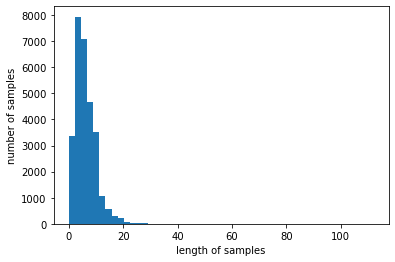

In [244]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [245]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [246]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 99.46431657162606


## 모든 샘플의 길이를 max_len로 조정

In [247]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [248]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  737,  171,   17, 2133,  277,  132])

## 모델 적용

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Embedding, Bidirectional,TimeDistributed
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [250]:
# 결과값 seq to seq : many to many

In [251]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 가사입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 가사입니다.\n".format((1 - score) * 100))

> https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte

In [277]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, None) <dtype: 'float32'>
(None, 7) <dtype: 'float32'>
embedding_10 (None, None) float32
bidirectional_10 (None, None, 300) float32
dense_38 (None, 256) float32
dense_39 (None, 64) float32
dense_40 (None, 32) float32
dense_41 (None, 16) float32


[None, None, None, None, None, None]

In [258]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(7,activation='sigmoid')) # , activation='sigmoid'

In [259]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [276]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(7,activation='softmax')) # , activation='sigmoid'

In [274]:
model = Sequential()
model.add(LSTM(32, input_shape = (X_train.shape[0] + 1, 150),
return_sequences=True))
model.add(LSTM(32)) # 입력 퍼셉트론 수
model.add(Dropout(0.3))
model.add(Dense(30, activation="relu", kernel_initializer='he_normal'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test,
y_test), callbacks=[es,mc], batch_size=X_train.shape[0])


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape = (new_Series.shape[0] + 1, 150),
return_sequences=True))
model.add(LSTM(32)) # 입력 퍼셉트론 수
model.add(Dropout(0.3))
model.add(Dense(30, activation="relu", kernel_initializer='he_normal'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test,
Y_test), callbacks=[es,mc], batch_size=X_train.shape[0])


In [279]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=X_train.shape[0], validation_data=(X_test,
y_test)) # , validation_split=0.2

Epoch 1/15


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (28935, 1) and (28935, 7) are incompatible


### Error
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python
> https://midannii.github.io/deeplearning/2021/02/25/DataType.html

In [263]:
print(X_train.shape, y_train.shape, X_test.shape,y_test.shape)

(28935, 20) (28935,) (9639, 20) (9639,)


In [268]:
print(type(X_train),type(y_train),type(X_test),type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


---

In [278]:
X_train=np.asarray(X_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)

In [214]:
# int인 X에 대해,
X_train=np.asarray(X_train).astype(np.int)

# float인 y에 대해,
y_train=np.asarray(y_train).astype(np.int)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape,y_test.shape)

In [215]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, 
                   validation_data=(X_test,y_test))

Epoch 1/15


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1754 binary_crossentropy
        backend.binary_crossentropy(
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:5023 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 7) vs (None, 1))


## Error
  ValueError: Shapes (None, 1) and (None, 20, 7) are incompatible<br>
    ValueError: logits and labels must have the same shape ((None, 7) vs (None, 1))

---

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 문장입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 문장입니다.\n".format((1 - score) * 100))

In [ ]:
data_list = []
for q, label in zip(emotion['Sentence'], emotion['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

---

### 감정 데이터 셋 `행복 / 슬픔` 데이터 만으로 모델 구현

In [291]:
emotion.shape

(38592, 2)

In [327]:
sdf['Emotion'] = 0 # 슬픔
sdf.head(3)

,Sentence,Emotion
17031,어깨라도넓엇으면 옷빨이라도 잘살텐데,0
17032,그저 보고싶어죽겟어요,0
17033,아 진짜 저한테는 악운만 붙는거같네요ㅠㅠ,0


In [326]:
jdf['Emotion'] = 1 # 행복
jdf.head(3)

,Sentence,Emotion
27128,유재석 오라버니 해피투게더 봤어요,1
27129,우리모두 준혁이성과 선수들이 선전할수 있게 기를 넣어줍시다,1
27130,웃긴거 알죠ㅋㅋㅇ ㅏ,1


In [328]:
bi_df = jdf.append(sdf).reset_index(drop=True)

In [331]:
print(bi_df.isnull().sum())
print(bi_df.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(bi_df)) # 데이터 개수

Sentence    0
Emotion     0
dtype: int64
False
11303


## 전처리

In [333]:
bi_df['Sentence'] = bi_df['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
bi_df[:5]

,Sentence,Emotion
0,유재석 오라버니 해피투게더 봤어요,1
1,우리모두 준혁이성과 선수들이 선전할수 있게 기를 넣어줍시다,1
2,웃긴거 알죠ㅋㅋㅇ ㅏ,1
3,덕분에 주방에서 요리하는게 넘 좋아졌어요,1
4,마지막 순간 손가락으로 총을 만들어 쏘실때에는 제가 직접 맞는 것 같습니다,1


In [334]:
bi_df['Sentence'] = bi_df['Sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
bi_df['Sentence'].replace('', np.nan, inplace=True)
print(bi_df.isnull().sum())

Sentence    0
Emotion     0
dtype: int64


In [336]:
print('전처리 후 데이터의 개수 :',len(bi_df))

전처리 후 데이터의 개수 : 11303


## 데이터 분리

In [337]:
train_data, test_data = train_test_split(
  bi_df,
  test_size = 0.25,
  random_state = 5
)

In [338]:
# 학습 데이터
X_train = []
for sentence in tqdm(train_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 8477/8477 [00:10<00:00, 812.07it/s]


In [339]:
# 테스트 데이터 
X_test = []
for sentence in tqdm(test_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 2826/2826 [00:03<00:00, 781.50it/s]


## 정답 데이터 저장 

In [340]:
y_train = np.array(train_data['Emotion'])
y_test = np.array(test_data['Emotion'])

In [341]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(drop_train)

[72, 95, 113, 963, 1990, 4083, 5376]


In [342]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

8470
8470
2826
2826
2824
2824


In [343]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [344]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [345]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [346]:
print(X_train[:1])

[[1036, 4122, 1, 1037, 23, 1148]]


## 패딩

문장의 최대 길이 : 33
문장의 평균 길이 : 6.058559622195986


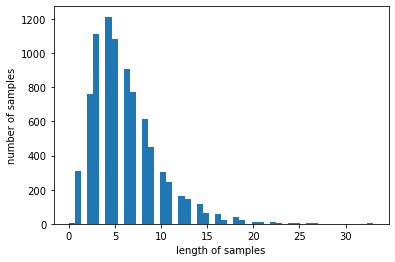

In [347]:
# 패딩
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [348]:
# 샘플 길이 확인
max_len = 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 97.61511216056671


In [349]:
# 길이 조정
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [350]:
# 모델 적용
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation='sigmoid')) # , activation='sigmoid'

In [351]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
106/106 [==============================] - 32s 161ms/step - loss: 0.4341 - acc: 0.8208 - val_loss: 0.2851 - val_acc: 0.8778

Epoch 00001: val_acc improved from -inf to 0.87780, saving model to best_model.h5
Epoch 2/15
106/106 [==============================] - 13s 123ms/step - loss: 0.1594 - acc: 0.9423 - val_loss: 0.3067 - val_acc: 0.8790

Epoch 00002: val_acc improved from 0.87780 to 0.87898, saving model to best_model.h5
Epoch 3/15
106/106 [==============================] - 12s 118ms/step - loss: 0.0777 - acc: 0.9734 - val_loss: 0.3685 - val_acc: 0.8701

Epoch 00003: val_acc did not improve from 0.87898
Epoch 4/15
106/106 [==============================] - 14s 130ms/step - loss: 0.0455 - acc: 0.9841 - val_loss: 0.4788 - val_acc: 0.8713

Epoch 00004: val_acc did not improve from 0.87898
Epoch 5/15
106/106 [==============================] - 15s 141ms/step - loss: 0.0233 - acc: 0.9900 - val_loss: 0.6719 - val_acc: 0.8672

Epoch 00005: val_acc did not improve from 0.87898
Epo

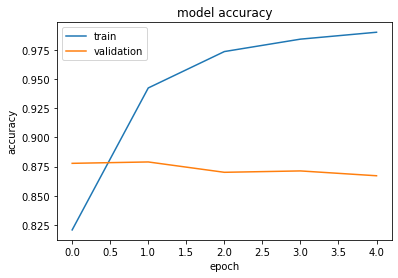

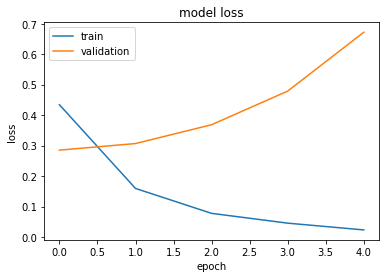

In [352]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [353]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

100.00% 확률로 부정 가사입니다.



In [354]:
 sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

80.88% 확률로 부정 가사입니다.



In [355]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

73.08% 확률로 부정 가사입니다.



In [356]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

99.98% 확률로 부정 가사입니다.



In [357]:
 sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와')

99.97% 확률로 긍정 가사입니다.



In [358]:
sentiment_predict('넌 그대로가 사랑이니까 이대로가 좋다 했지')

96.20% 확률로 긍정 가사입니다.



In [359]:
sentiment_predict('손을잡아 너와 함께 난 언제라도 따듯한 폭닥한 이불 널 보면 생각나')

100.00% 확률로 부정 가사입니다.

